In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from glob import glob

In [ ]:
class Filter():
    
    # mean filter
    def mean_filter(self,image:np.array,kernel_size=(3,3)) -> np.array: 
        ndim = image.ndim
        image = image
        kernel = np.ones(kernel_size) / (kernel_size[0]*kernel_size[1]) # mean kernel 생성
        pad_size = (kernel_size[0] - 1) // 2

        # gray scale image면,
        if ndim == 2:
            output = np.zeros_like(image,dtype=float) # output array 미리 생성
            pad_image = self._pad(image,pad_width=((pad_size,pad_size),(pad_size,pad_size))) # image의 크기를 위해 padding하는 함수를 따로 생성
            window_generator = self._sliding_window(pad_image,pad_size) # padding된 image를 sliding window할 수 있도록 generator를 생성

            x = 0
            y = 0
            # window를 sliding하면서 convolution 실행
            for window in window_generator:
                output[x,y] = np.sum(window*kernel)
                y += 1
                if y == output.shape[1]:
                    x +=1
                    y = 0
        else:
            # color image면 hsi채널로 convert
            hsi = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
            # i channel만 연산 수행
            output = np.zeros_like(hsi[:,:,2],dtype=float)
            pad_i = self._pad(hsi[:,:,2],pad_width=((pad_size,pad_size),(pad_size,pad_size)))
            window_generator = self._sliding_window(pad_i,pad_size)

            x = 0
            y = 0
            for window in window_generator:
                output[x,y] = np.sum(window*kernel)
                y += 1
                if y == output.shape[1]:
                    x +=1
                    y = 0
            hsi[:,:,2] = output
            output = cv2.cvtColor(hsi,cv2.COLOR_HSV2BGR)

        return output

    # median filter
    def median_filter(self,image: np.array,kernel_size=(3,3)) -> np.array:

        if kernel_size[0] % 2 == 0:
            print("size must be odd")
            return -1
        ndim = image.ndim
        image = image
        pad_size = (kernel_size[0] - 1) // 2

        if ndim == 2:
            output = np.zeros_like(image,dtype=float)
            pad_image = self._pad(image,pad_width=((pad_size,pad_size),(pad_size,pad_size)))
            window_generator = self._sliding_window(pad_image,pad_size)

            x = 0
            y = 0
            for window in window_generator:
                output[x,y] = np.median(window) # window 별로 median값 구함
                y += 1
                if y == output.shape[1]:
                    x +=1
                    y = 0

        else:
            # color image의 경우 cv2의 medianBlur 함수로 대체
            output = cv2.medianBlur(image,kernel_size[0])
        return output

    # gaussian filter
    def gaussian_filter(self,image: np.array,kernel_size=(3,3),sigma=1) -> np.array:
        
        ndim = image.ndim
        image = image
        pad_size = (kernel_size[0] - 1) // 2
        kernel = self._make_gaussian_kernel(kernel_size[0],sigma) # gaussian kernel를 구하는 함수

        if ndim == 2:
            output = np.zeros_like(image,dtype=float)
            pad_image = self._pad(image,pad_width=((pad_size,pad_size),(pad_size,pad_size)))
            window_generator = self._sliding_window(pad_image,pad_size)

            x = 0
            y = 0
            for window in window_generator:
                output[x,y] = np.sum(window*kernel)
                y += 1
                if y == output.shape[1]:
                    x +=1
                    y = 0

        else:
            hsi = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
            output = np.zeros_like(hsi[:,:,2],dtype=float)
            pad_i = self._pad(hsi[:,:,2],pad_width=((pad_size,pad_size),(pad_size,pad_size)))
            window_generator = self._sliding_window(pad_i,pad_size)

            x = 0
            y = 0
            for window in window_generator:
                output[x,y] = np.sum(window*kernel)
                y += 1
                if y == output.shape[1]:
                    x +=1
                    y = 0
            hsi[:,:,2] = output
            output = cv2.cvtColor(hsi,cv2.COLOR_HSV2BGR)
        return output
    
    def high_boost_filter(self,image: np.array,kernel_size=(3,3),alpha = 1.2,use_highpass = True,for_high='N8') -> np.array:
        ndim = image.ndim
        image = image
        pad_size = (kernel_size[0] - 1) // 2

        if ndim == 2:
            kernel = self._make_hight_boost_kernel(kernel_size,alpha,use_highpass,for_high) # high boost filter 생성, use_highpass가 True면 high frequency를 더해주는 방식, False면 low frequency를 빼주는 방식, for_high가 N8이면 8 neighbor사용, N4면 4 neighbor 사용
            output = np.zeros_like(image,dtype=float)
            pad_image = self._pad(image,pad_width=((pad_size,pad_size),(pad_size,pad_size)))
            window_generator = self._sliding_window(pad_image,pad_size)

            x = 0
            y = 0
            for window in window_generator:
                output[x,y] = np.sum(window*kernel)
                y += 1
                if y == output.shape[1]:
                    x +=1
                    y = 0
        else:
            kernel = self._make_high_boost_kernel(kernel_size,alpha,use_highpass,for_high)
            hsi = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
            output = np.zeros_like(hsi[:,:,2],dtype=float)
            pad_i = self._pad(hsi[:,:,2],pad_width=((pad_size,pad_size),(pad_size,pad_size)))
            window_generator = self._sliding_window(pad_i,pad_size)

            x = 0
            y = 0
            for window in window_generator:
                output[x,y] = np.sum(window*kernel)
                y += 1
                if y == output.shape[1]:
                    x +=1
                    y = 0
            hsi[:,:,2] = output
            output = cv2.cvtColor(hsi,cv2.COLOR_HSV2BGR)
        
        return output

    # reflect방식으로 padding 진행
    def _pad(self,image: np.array,pad_width = ((1,1),(1,1)),mode = 'reflect') -> np.array:

        padding_image = np.pad(image,pad_width,mode=mode)

        return padding_image

    # sliding window를 구현하는 generator. kernel size만큼 씩 yield를 통해 generate
    def _sliding_window(self,image: np.array,pad_size,step_size = 1) -> np.array:
        
        (height, width) = image.shape[:2]

        for y in range(pad_size,height-pad_size,step_size):
            for x in range(pad_size,width-pad_size,step_size):
                window = image[y-pad_size:y + pad_size+1, x-pad_size:x + pad_size+1]
                
                yield window

    # 3X3으로만 high boost filter 생성
    def _make_high_boost_kernel(self,kernel_size,alpha,use_highpass,for_high):
        if use_highpass:
            # 8 neighbor
                if for_high == 'N8':
                    center = kernel_size[0]//2
                    kernel = np.full(kernel_size,-1.0,dtype=float)
                    kernel[center,center] = 0
                    kernel[center,center] = alpha + (abs(np.sum(kernel)))
                    
            # 4 neighbor
                elif for_high == 'N4':
                    center = kernel_size[0]//2
                    kernel = np.zeros(kernel_size,dtype=float)
                    kernel[center-1,center] = -1
                    kernel[center+1,center] = -1
                    kernel[center,center-1] = -1
                    kernel[center,center+1] = -1
                    kernel[center,center] = alpha + (abs(np.sum(kernel)))
                    
        else:
            # low pass를 뺌
            center = kernel_size[0]//2
            tmp_kernel = np.zeros(kernel_size,dtype=float)
            tmp_kernel[center,center] = alpha
            kernel = np.ones(kernel_size) / (kernel_size[0]*kernel_size[1])
            kernel = tmp_kernel - kernel
            

        return kernel

    def _make_gaussian_kernel(self,size,sigma=1):

        # 커널 크기가 홀수인 경우와 짝수인 경우 나누어서 구현
        if size%2 == 1:
            center = (size-1)//2
            x, y = np.mgrid[-center:center+1, -center:center+1]
        else:
            half = size//2
            x, y = np.mgrid[-half:half+1, -half:half+1]
        
        # 가우시안 커널 생성
        kernel = np.exp(-(x**2+y**2)/(2*sigma**2))
        kernel /= kernel.sum()
        
        return kernel
                

In [ ]:
sf = Filter()

In [ ]:
image_list = glob('/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/*')
image_list

['/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/test image',
 '/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/Homework #3 images',
 '/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/Filter']

In [ ]:
homework_images_path = glob(image_list[2]+'/*')
homework_images_path

['/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/Filter/Filter.ipynb']

In [ ]:
test_images_path = glob(image_list[1]+'/*')
test_images_path

['/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/Homework #3 images/noisy image',
 '/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/Homework #3 images/Color noisy image',
 '/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/Homework #3 images/High-boost filter images']

## Noisy filter

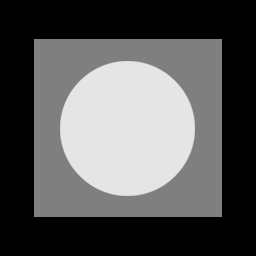

In [ ]:
# noisy image
noisy_origin = cv2.imread('/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/Homework #3 images/noisy image/Fig0503 (original_pattern).jpg',cv2.IMREAD_GRAYSCALE)
cv2_imshow(noisy_origin)

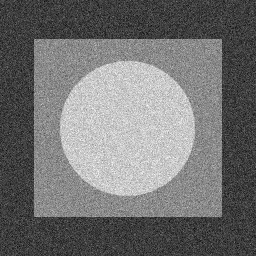

3x3kernel gaussian filter


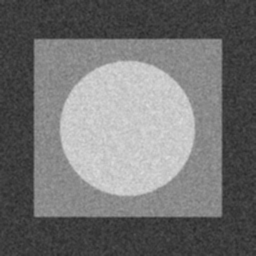

5x5kernel gaussian filter


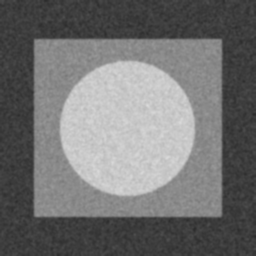

In [ ]:
noisy_gaussian = cv2.imread('/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/Homework #3 images/noisy image/Fig0504(a)(gaussian-noise).jpg',cv2.IMREAD_GRAYSCALE)
cv2_imshow(noisy_gaussian)

print('3x3kernel gaussian filter')
gaussian_filter = sf.gaussian_filter(noisy_gaussian)
cv2_imshow(gaussian_filter)

print('5x5kernel gaussian filter')
gaussian_filter = sf.gaussian_filter(noisy_gaussian,kernel_size=(5,5))
cv2_imshow(gaussian_filter)

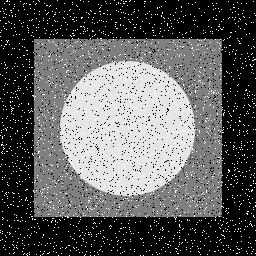

3x3kernel median filter


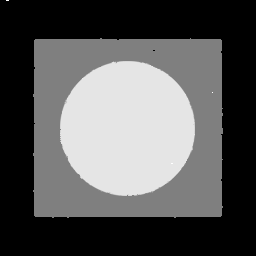

5x5kernel median filter


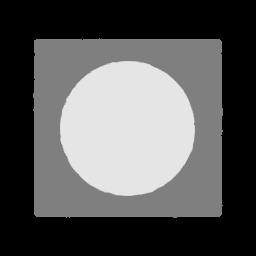

In [ ]:
noisy_salt_pepper = cv2.imread('/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/Homework #3 images/noisy image/Fig0504(i)(salt-pepper-noise).jpg',cv2.IMREAD_GRAYSCALE)
cv2_imshow(noisy_salt_pepper)

print('3x3kernel median filter')
median_filter = sf.median_filter(noisy_salt_pepper)
cv2_imshow(median_filter)

print('5x5kernel median filter')
median_filter = sf.median_filter(noisy_salt_pepper,kernel_size=(5,5))
cv2_imshow(median_filter)

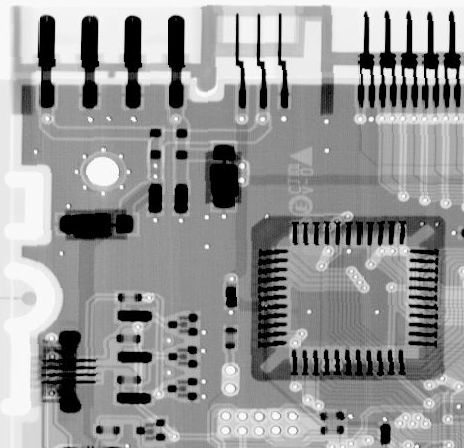

In [ ]:
# noisy image
noisy_origin = cv2.imread('/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/Homework #3 images/noisy image/Fig0507(a)(ckt-board-orig).jpg',cv2.IMREAD_GRAYSCALE)
cv2_imshow(noisy_origin)

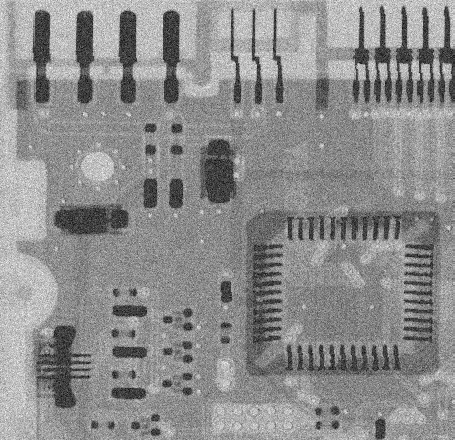

3x3kernel gaussian filter


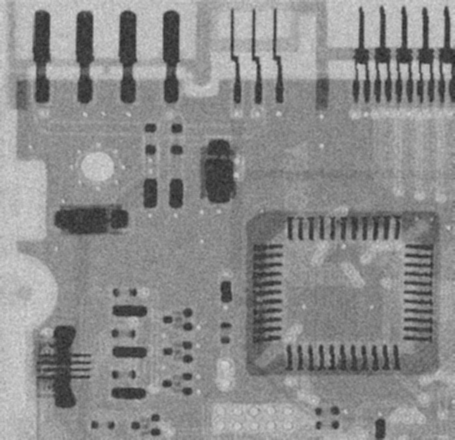

5x5kernel gaussian filter


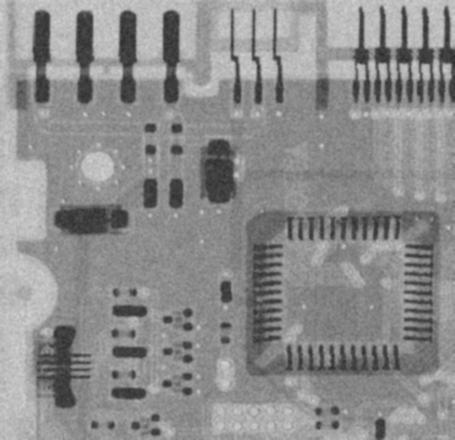

In [ ]:
noisy_gaussian = cv2.imread('/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/Homework #3 images/noisy image/Fig0513(a)(ckt_gaussian_var_1000_mean_0).jpg',cv2.IMREAD_GRAYSCALE)
cv2_imshow(noisy_gaussian)

print('3x3kernel gaussian filter')
gaussian_filter = sf.gaussian_filter(noisy_gaussian)
cv2_imshow(gaussian_filter)

print('5x5kernel gaussian filter')
gaussian_filter = sf.gaussian_filter(noisy_gaussian,kernel_size=(5,5))
cv2_imshow(gaussian_filter)

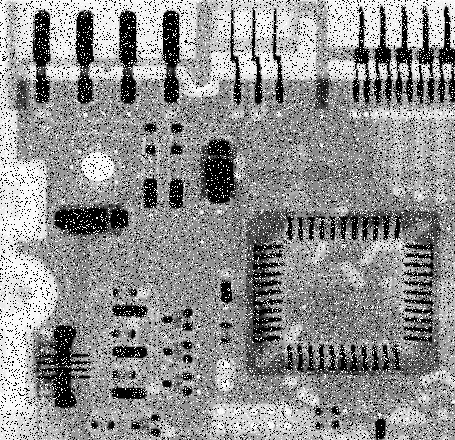

3x3kernel median filter


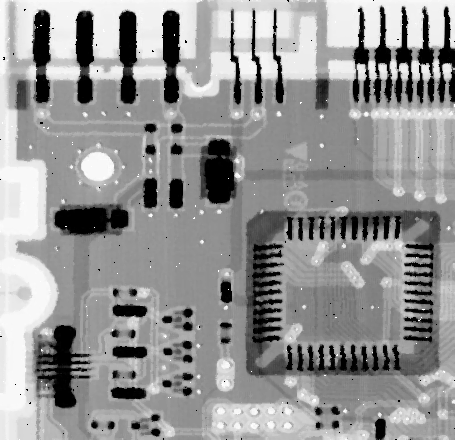

5x5kernel median filter


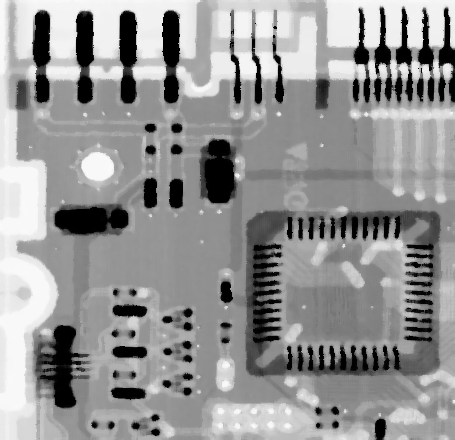

In [ ]:
noisy_salt_pepper = cv2.imread('/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/Homework #3 images/noisy image/Fig0510(a)(ckt-board-saltpep-prob.pt05).jpg',cv2.IMREAD_GRAYSCALE)
cv2_imshow(noisy_salt_pepper)

print('3x3kernel median filter')
median_filter = sf.median_filter(noisy_salt_pepper)
cv2_imshow(median_filter)

print('5x5kernel median filter')
median_filter = sf.median_filter(noisy_salt_pepper,kernel_size=(5,5))
cv2_imshow(median_filter)

## Color noise

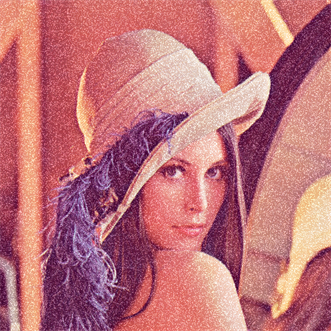

In [ ]:
# noisy color image
noisy_origin = cv2.imread('/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/Homework #3 images/Color noisy image/Lena_noise.png')
cv2_imshow(noisy_origin)

In [ ]:
noisy_gaussian = cv2.imread('/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/Homework #3 images/Color noisy image/Gaussian noise.png')
cv2_imshow(noisy_gaussian)

print('3x3kernel gaussian filter')
gaussian_filter = sf.gaussian_filter(noisy_gaussian)
cv2_imshow(gaussian_filter)

print('5x5kernel gaussian filter')
gaussian_filter = sf.gaussian_filter(noisy_gaussian,kernel_size=(5,5))
cv2_imshow(gaussian_filter)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
noisy_salt_pepper = cv2.imread('/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/Homework #3 images/Color noisy image/Salt&pepper noise.png')
cv2_imshow(noisy_salt_pepper)

print('3x3kernel median filter')
median_filter = sf.median_filter(noisy_salt_pepper)
cv2_imshow(median_filter)

print('5x5kernel median filter')
median_filter = sf.median_filter(noisy_salt_pepper,kernel_size=(5,5))
cv2_imshow(median_filter)

Output hidden; open in https://colab.research.google.com to view.

## high boost

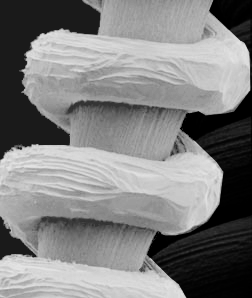

3x3kernel alpha1.2 +high frequency filter


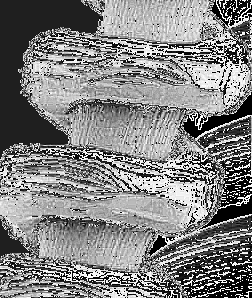

3x3kernel alpha1.6 +low frequency filter


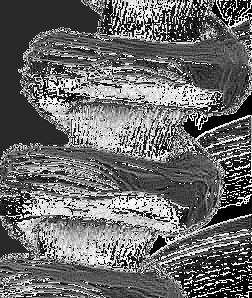

In [ ]:
# noisy color image
high_boost_origin = cv2.imread('/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/Homework #3 images/High-boost filter images/Fig0327(a)(tungsten_original).jpg')
cv2_imshow(high_boost_origin)

print('3x3kernel alpha1.2 +high frequency filter')
high_filter = sf.high_boost_filter(high_boost_origin,alpha=1.2,use_highpass=True,for_high='N8')
cv2_imshow(high_filter)

print('3x3kernel alpha1.6 +low frequency filter')
high_filter = sf.high_boost_filter(high_boost_origin,alpha=1.6,use_highpass=True,for_high='N8')
cv2_imshow(high_filter)

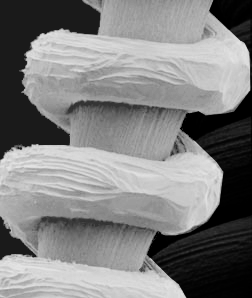

3x3kernel alpha1.2 -low frequency filter


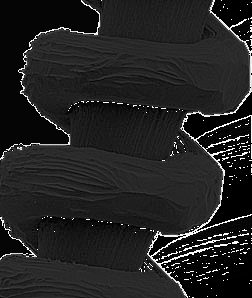

3x3kernel alpha1.6 +low frequency filter


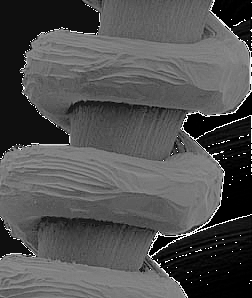

In [ ]:
# noisy color image
high_boost_origin = cv2.imread('/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/Homework #3 images/High-boost filter images/Fig0327(a)(tungsten_original).jpg')
cv2_imshow(high_boost_origin)

print('3x3kernel alpha1.2 -low frequency filter')
low_filter = sf.high_boost_filter(high_boost_origin,alpha=1.2,use_highpass=False,for_high='N8')
cv2_imshow(low_filter)

print('3x3kernel alpha1.6 +low frequency filter')
low_filter = sf.high_boost_filter(high_boost_origin,alpha=1.6,use_highpass=False,for_high='N8')
cv2_imshow(low_filter)

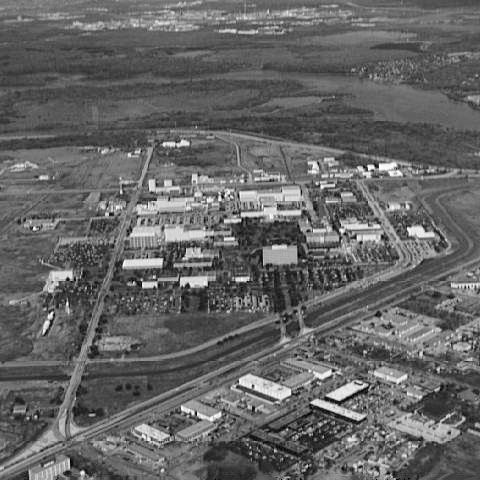

3x3kernel alpha1.2 +high frequency filter


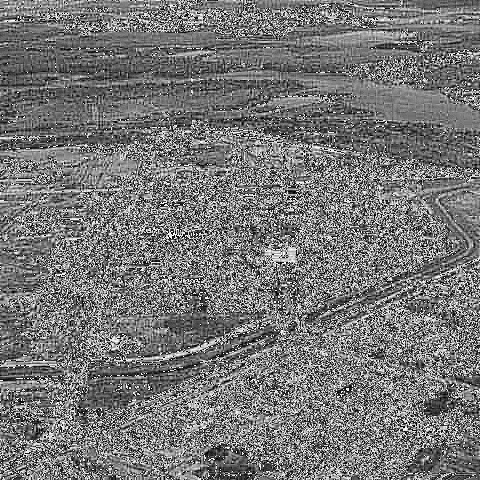

3x3kernel alpha1.6 +low frequency filter


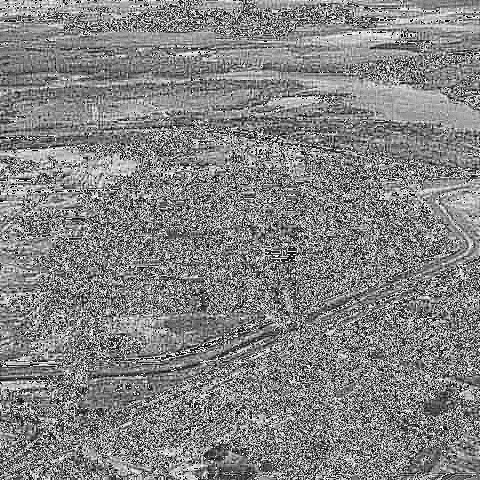

In [ ]:
# noisy color image
high_boost_origin = cv2.imread('/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/Homework #3 images/High-boost filter images/Fig0525(a)(aerial_view_no_turb).jpg')
cv2_imshow(high_boost_origin)

print('3x3kernel alpha1.2 +high frequency filter')
high_filter = sf.high_boost_filter(high_boost_origin,alpha=1.2,use_highpass=True,for_high='N8')
cv2_imshow(high_filter)

print('3x3kernel alpha1.6 +low frequency filter')
high_filter = sf.high_boost_filter(high_boost_origin,alpha=1.6,use_highpass=True,for_high='N8')
cv2_imshow(high_filter)

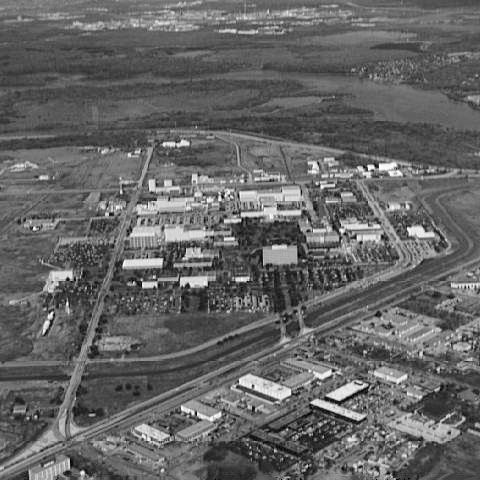

3x3kernel alpha1.2 -low frequency filter


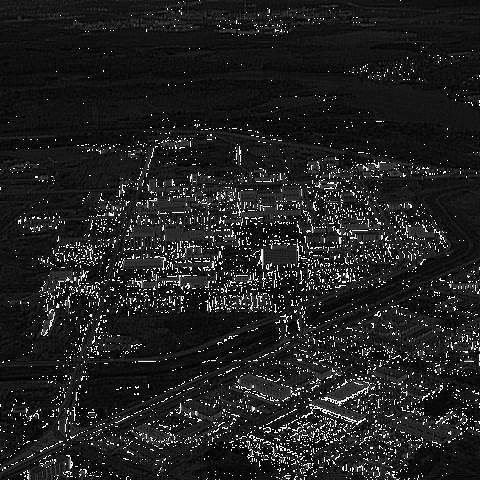

3x3kernel alpha1.6 +low frequency filter


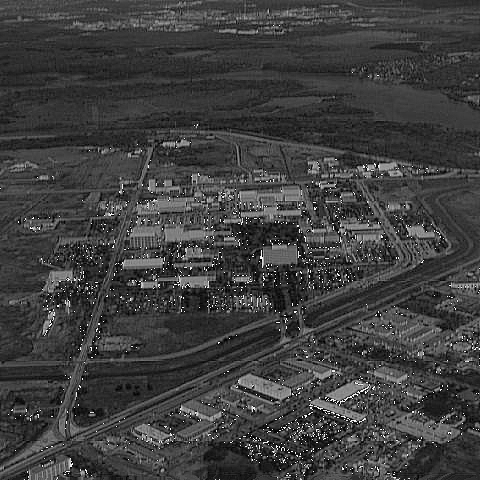

In [ ]:
# noisy color image
high_boost_origin = cv2.imread('/content/drive/Othercomputers/내 컴퓨터/Konkuk_ML/DigitalProcessing/homework1/Homework #3 images/High-boost filter images/Fig0525(a)(aerial_view_no_turb).jpg')
cv2_imshow(high_boost_origin)

print('3x3kernel alpha1.2 -low frequency filter')
low_filter = sf.high_boost_filter(high_boost_origin,alpha=1.2,use_highpass=False,for_high='N8')
cv2_imshow(low_filter)

print('3x3kernel alpha1.6 +low frequency filter')
low_filter = sf.high_boost_filter(high_boost_origin,alpha=1.6,use_highpass=False,for_high='N8')
cv2_imshow(low_filter)